In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader, Subset,random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision import datasets
import torch._dynamo
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights
import glob
from torch.utils.data import Dataset



torch._dynamo.config.suppress_errors = True


# Check for CUDA and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()

# Define the directory of my dataset
data_dir = "./DATA_LABELS"  # Modify with your correct path

#creating the neural network model

# load the VGG16 network *pre-trained* on the ImageNet dataset
weights = VGG16_Weights.DEFAULT
vgg_model = vgg16(weights=weights)
vgg_model.to(device) #load to device

#freeze the base model
vgg_model.requires_grad_(False)
print("VGG16 Frozen")
N_CLASSES = 3
#Adding New Layers
vgg_model.classifier[6] = nn.Sequential(
    nn.Linear(in_features=4096, out_features=256), #add a Linear layer connecting VGG16's outputs to 256 neurons
    nn.LeakyReLU(), #activation layer
    nn.Dropout(p=0.2), #dropout to prevent overfitting
    nn.Linear(in_features=256, out_features=N_CLASSES) #  linear layer maps the 256 features to N_CLASSES classes
)
vgg_model.to(device)

#make sure that the layers are frozen except the new ones
for idx, param in enumerate(vgg_model.parameters()):
    print(idx, param.requires_grad)


pre_trans = weights.transforms() #preprocessing transforms from the VGG weights

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHS = 3
N_CLASSES = 3


#augmentation
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),#20% chance to flip images horizontally
    transforms.RandomVerticalFlip(p=0.2),  # 20% chance to vertically flip the image
])


#read image files directly and infer the label based on the filepath
# the dataset class defining

DATA_LABELS = ["GPCR_PROTEIN", "Ras_proteins", "tyrosine_kinase"]

class MyDataset(Dataset):
    def __init__(self, data_dir):
        self.img_paths = []
        self.labels = []
        
        for l_idx, label in enumerate(DATA_LABELS):
            data_paths = glob.glob(data_dir + '/' + label + '/*.jpeg', recursive=True)
            print(f"Label: {label}, Found {len(data_paths)} images")  # Debugging
            for path in data_paths:
                self.img_paths.append(path)
                self.labels.append(l_idx)

    def __getitem__(self, idx):
        path = self.img_paths[idx]
        img = pre_trans(Image.open(path))  # Apply pre-transformations
        label = torch.tensor(self.labels[idx], dtype=torch.long) # convert to tensor

        return img, label

    def __len__(self):
        return len(self.img_paths)

# Instantiate dataset
dataset = MyDataset(data_dir)
print(f"Total dataset size: {len(dataset)}") #check

# Splitting datasets
    

# Extract labels for stratified splitting
labels = np.array([dataset[i][1] for i in range(len(dataset))])  # Extract labels
# 10% of the data as test
train_val_indices, test_indices, train_val_labels, _ = train_test_split(
    np.arange(len(labels)),
    labels,
    test_size=0.1,
    stratify=labels,
    random_state=42
)

# temporary set into validation 20% and train 80%
val_size = .2  # Validation proportion 20%
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices,
    train_val_labels,
    test_size=val_size,
    stratify=train_val_labels,
    random_state=42
)

#Create subsets for train, validation, and test
train_dataset = Subset(dataset, train_indices)
valid_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Dataset sizes
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)
test_N = len(test_loader.dataset)
#print the size 
print('train size',train_N)
print('valid size',valid_N)
print('test size',test_N)


#accuracy function

def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N


# the training function

train_losses, train_accuracies = [], [] #creating two variables to store the accuracy and loss over the epoches 
def train(train_loader ,train_N,check_grad=False):
    loss = 0
    accuracy = 0

    vgg_model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = torch.squeeze(vgg_model(images))
        optimizer.zero_grad()
        batch_loss = loss_function(output, labels)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, labels, train_N)
    if check_grad:
        print('Last Gradient:')
        for param in vgg_model.parameters():
            print(param.grad)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    train_loss = loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)

#validation function

valid_losses,valid_accuracies = [],[]#creating two variables to store the accuracy and loss over the epoches
def validate(valid_loader,valid_N):
    loss = 0
    accuracy = 0

    vgg_model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = vgg_model(images)

            loss += loss_function(output, labels).item()
            accuracy += get_batch_accuracy(output, labels, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    valid_loss = loss / len(valid_loader)
    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

#training loop

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, valid_loss):
        if self.best_loss is None:
            self.best_loss = valid_loss
        elif valid_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = valid_loss
            self.counter = 0

# Initialize  optimizer and loss function
loss_function = nn.CrossEntropyLoss()
    # Define the optimizer with L2 weight decay
optimizer = Adam(vgg_model.parameters(), lr=0.0001, weight_decay=1e-4)

    # Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)
 # Training epochs
epochs = 30
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train(train_loader, train_N)
    validate(valid_loader, valid_N)

    # Early stopping
    early_stopping(valid_losses[-1])
    if early_stopping.early_stop:
         print("Early stopping triggered.")
         break


cuda
VGG16 Frozen
0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 True
31 True
32 True
33 True
Label: GPCR_PROTEIN, Found 998 images
Label: Ras_proteins, Found 923 images
Label: tyrosine_kinase, Found 998 images
Total dataset size: 2919
train size 2101
valid size 526
test size 292

Epoch 1/30
Train - Loss: 27.6069 Accuracy: 0.6659
Valid - Loss: 5.6248 Accuracy: 0.7776

Epoch 2/30
Train - Loss: 20.2798 Accuracy: 0.7682
Valid - Loss: 4.9384 Accuracy: 0.7814

Epoch 3/30
Train - Loss: 18.2883 Accuracy: 0.7825
Valid - Loss: 4.7397 Accuracy: 0.7814

Epoch 4/30
Train - Loss: 17.5132 Accuracy: 0.7882
Valid - Loss: 4.5526 Accuracy: 0.8004

Epoch 5/30
Train - Loss: 16.8543 Accuracy: 0.8053
Valid - Loss: 4.3749 Accuracy: 0.8042

Epoch 6/30
Train - Loss: 16.2734 Accuracy: 0.8001
Valid -

fine tuning

In [4]:

 # Unfreeze the base model for final tuning
vgg_model.requires_grad_(True)
optimizer = Adam(vgg_model.parameters(), lr=0.00001, weight_decay=1e-4)# optimizer
 # Training epochs
epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train(train_loader, train_N)
    validate(valid_loader, valid_N)

    # Early stopping
    early_stopping(valid_losses[-1])
    if early_stopping.early_stop:
         print("Early stopping triggered.")
         break




Epoch 1/3
Train - Loss: 11.2268 Accuracy: 0.8639
Valid - Loss: 3.3506 Accuracy: 0.8536

Epoch 2/3
Train - Loss: 7.7038 Accuracy: 0.9039
Valid - Loss: 3.1141 Accuracy: 0.8669

Epoch 3/3
Train - Loss: 5.3309 Accuracy: 0.9400
Valid - Loss: 3.1319 Accuracy: 0.8783
EarlyStopping counter: 1 out of 5


Visualize Losses

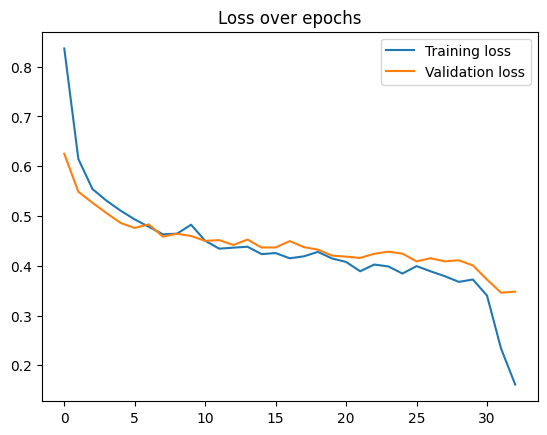

In [5]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

Visualize Losses

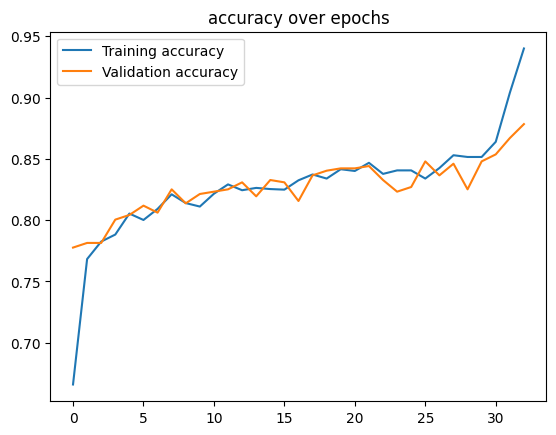

In [6]:
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Validation accuracy')
plt.legend()
plt.title("accuracy over epochs")
plt.show()

evaluation function 

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       100
           1       0.92      0.77      0.84        92
           2       0.85      0.89      0.87       100

    accuracy                           0.86       292
   macro avg       0.87      0.86      0.86       292
weighted avg       0.86      0.86      0.86       292

Confusion Matrix:
[[91  5  4]
 [ 9 71 12]
 [10  1 89]]
accuracy score: 0.8595890410958904
area under the curve: 0.9713488828502416


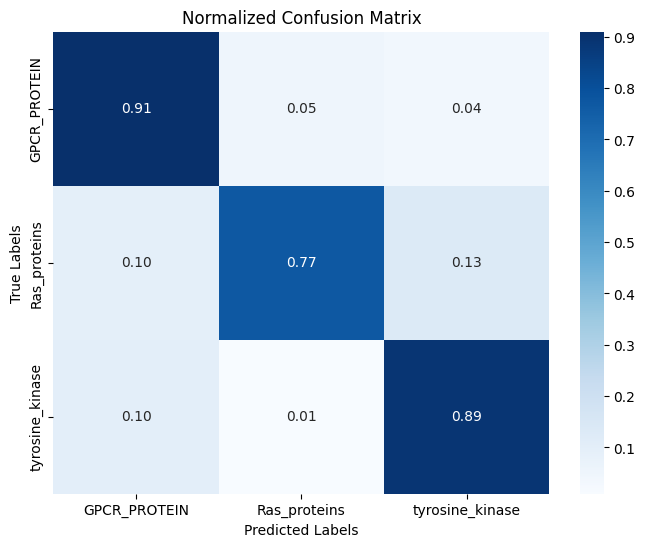

In [7]:

from torchvision.datasets import ImageFolder
class_names=ImageFolder(data_dir).classes#getting the classes names

import torch.nn.functional as F
import seaborn as sns
y_true = []
y_pred = []
y_prob=[]
def evaluate():
    
    vgg_model.eval()  #Puts the model in evaluation mode.
    

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device) 
            labels =labels.to(device)
            outputs = vgg_model(images)
            _, predicted = torch.max(outputs, 1)
            # Apply softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(probabilities.cpu().numpy())  # Predicted probabilities

    print("Classification Report:")
    print(classification_report(y_true, y_pred)) #provides precision, recall, F1-score, and accuracy for each class.

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred)) # visualizes the performance of the classification
    
    
evaluate()
from sklearn.metrics import accuracy_score, roc_auc_score

auc = accuracy_score(y_true, y_pred) #get the accuracy score
print("accuracy score:", auc)
auc = roc_auc_score(y_true, y_prob, multi_class="ovr")#get the area under curve
print("area under the curve:", auc)


#define plot function for the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
 
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", 
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
#getting the classes names
plot_confusion_matrix(y_true, y_pred, class_names) #plotting the matrix

